In [2]:
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.recommend.user_knn import *
from src.recommend.utils import *
import tqdm
import warnings
import matplotlib

In [3]:
def convert_vector(b):
    n = len(b)
    valid_idx = np.where(~np.isnan(b))[0] #2d vector of nx1, only want row index of valid values
    D0 = np.ones([n, len(valid_idx)])
    for i, val in enumerate(valid_idx):
        D0[val, i] = np.nan
    B = b * D0 # broacast
    return B

In [4]:
d = './processed/filtered/'
album_df, user_dfs = load_dataframes(d)
(user_train_df, user_val_df, user_test_df) = user_dfs

In [5]:
X_train = generate_user_item_matrix(user_train_df, album_df)
X_val = generate_user_item_matrix(user_val_df, album_df)
X_test = generate_user_item_matrix(user_test_df, album_df)

In [6]:
# convert from user-rating to rating-user
X_train = X_train.T
X_test = X_test.T

In [43]:
random.seed(42)
N = 10
test_idx_n = random.sample(range(X_test.shape[1]), k=N)

In [44]:
np.sum(~np.isnan(X_test[:, test_idx_n]), axis=0)

array([351,  20, 175,  22,  40, 422,  25,  13,  31,  22])

In [45]:
#convert 0 to Nan
X_train = X_train.astype('float')
X_test = X_test.astype('float')
X_train[X_train == 0.0] = np.nan
X_test[X_test == 0.0] = np.nan

## Strong Generalization

In [46]:
uk = UserKNN(X_train)

In [47]:
def strong_gen_preds(uk, X_test, sample_idx=[0]):
    P_list = []
    for i in tqdm.tqdm(sample_idx):
        b = X_test[:,i].reshape([-1,1])
        uk.B = convert_vector(b)
        uk.b_valid_idx = np.where(~np.isnan(b))[0]
        uk.gen_M(strong=True)
        uk.gen_mu(strong=True)
        uk.gen_corrcoef(strong=True) # one vector of test data, 3:22 (17,733 train vectors, 86 test vectors perturbations)
        uk.gen_preds(strong=True)
        P_list.append(uk.P_strong)
    return P_list

In [48]:
warnings.filterwarnings("ignore")
strong_Pn = strong_gen_preds(uk, X_test, sample_idx=test_idx_n)

100%|██████████| 10/10 [1:14:15<00:00, 445.58s/it]


In [61]:
b_true_list = []
b_valid_len = []
for i in range(N):
    idx = test_idx_n[i]
    b = X_test[:,idx].reshape([-1,1])
    b_valid_idx = np.where(~np.isnan(b))[0]
    b_true = np.array([b[v] for v in b_valid_idx]).squeeze()
    b_true_list.append(b_true.tolist())
    b_valid_len.append(len(b_true))

In [60]:
type(strong_Pn[0])

list

In [62]:
strong_gen_results = {
    'y_trues': b_true_list,
    'y_hats': strong_Pn,
    'test_idx':  test_idx_n
}
with open('strong_generalization_10raters_results.json', 'w') as fp:
    json.dump(strong_gen_results, fp)


### SG Performance
Mean absolute error for each test user

In [64]:

for i, P in enumerate(strong_Pn):
    y_hat = np.array(P)
    y_true = np.array(b_true_list[i])
    print("---")
    print(f"Number of ratings for test user {i}: {len(P)}")
    print(f"Mean absolute error: {round(np.mean(abs(y_true - y_hat)),2)}")

---
Number of ratings for test user 0: 351
Mean absolute error: 9.99
---
Number of ratings for test user 1: 20
Mean absolute error: 6.63
---
Number of ratings for test user 2: 175
Mean absolute error: 7.41
---
Number of ratings for test user 3: 22
Mean absolute error: 9.27
---
Number of ratings for test user 4: 40
Mean absolute error: 5.86
---
Number of ratings for test user 5: 422
Mean absolute error: 7.19
---
Number of ratings for test user 6: 25
Mean absolute error: 6.0
---
Number of ratings for test user 7: 13
Mean absolute error: 7.03
---
Number of ratings for test user 8: 31
Mean absolute error: 8.35
---
Number of ratings for test user 9: 22
Mean absolute error: 10.98


In [67]:
y_hats = np.array([s for sublist in strong_Pn for s in sublist])
y_trues = np.array([s for sublist in b_true_list for s in sublist])
print(f"Mean absolute error: {round(np.mean(abs(y_trues - y_hats)),2)}")

Mean absolute error: 8.17


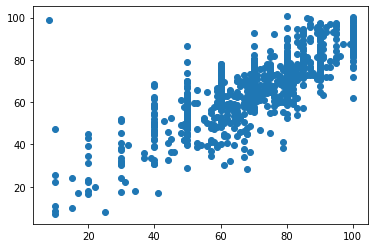

In [68]:
plt.scatter(y_trues, y_hats)

## Weak Generalization

In [56]:
wuk = UserKNN(X_train)

In [58]:
wuk.gen_valid_idx()
wuk.split_test_weak()
wuk.gen_M()
wuk.gen_mu()

In [62]:
wuk.gen_corrcoef()

In [63]:
wuk.gen_preds()

In [69]:
y_trues = []
y_hats = []
for t in wuk.A_test_idx:
    i, j = t
    y_true = wuk.A[i,j]
    y_hat = wuk.P[i,j]
    y_trues.append(y_true)
    y_hats.append(y_hat)
    #print(f'True value: {y_true}')
    #print(f'Pred value: {}')
    #print(f'Delta: {abs(wuk.A[i,j] - wuk.P[i,j])}')
y_trues = np.array(y_trues)
y_hats = np.array(y_hats)

In [ ]:
weak_gen_results = {
    'y_trues': y_trues,
    'y_hats': y_hats,
    'test_idx':  [(int(i), int(j) for i,j in wuk.A_test_idx)]
}
with open('weak_generalization_8020_results.json', 'w') as fp:
    json.dump(weak_gen_results, fp)

In [85]:
print(f'Number of test predictions {len(wuk.A_test_idx)}')
print(f'Mean absolute error: {round(np.mean(abs(y_trues - y_hats)),2)}')
print(f'RMSE: {np.sqrt(np.mean((y_trues - y_hats)**2))}')

Number of test predictions 585129
Mean absolute error: 8.58
RMSE: 11.827177880350877


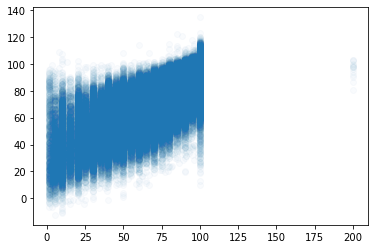

In [83]:
plt.scatter(x=y_trues, y=y_hats,alpha=0.025)

(array([2.00000e+00, 6.00000e+00, 1.80000e+01, 3.10000e+01, 4.30000e+01,
        4.70000e+01, 9.40000e+01, 1.59000e+02, 2.12000e+02, 3.55000e+02,
        4.96000e+02, 7.15000e+02, 1.12400e+03, 1.49400e+03, 2.33900e+03,
        3.62000e+03, 5.39300e+03, 8.35100e+03, 1.36520e+04, 2.39210e+04,
        4.39730e+04, 7.58340e+04, 1.05508e+05, 1.07008e+05, 8.33740e+04,
        5.23820e+04, 2.88230e+04, 1.40330e+04, 6.52500e+03, 2.93500e+03,
        1.37400e+03, 5.87000e+02, 3.32000e+02, 1.53000e+02, 7.40000e+01,
        4.60000e+01, 3.50000e+01, 1.70000e+01, 1.30000e+01, 9.00000e+00,
        3.00000e+00, 2.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00,
        3.00000e+00, 5.00000e+00, 3.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([-101.19952911,  -96.78960053,  -92.37967196,  -87.96974339,
         -83.55981482,  -79.14988624,  -74.73995767,  -70.3300291 ,
         -65.92010052,  -61.51017195,  -57.10024338,  -52.69031481,
         -48.28038623,  -43.87045766,  -39.46052909,  -35.050600

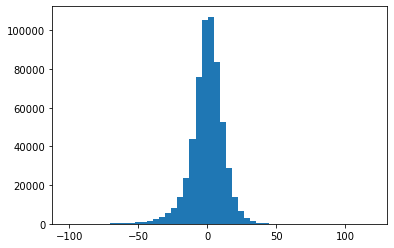

In [74]:
plt.hist(y_trues-y_hats, bins=50)